In [1]:
import numpy as np
import pandas as pd
from scipy import stats, sparse
import bottleneck
def run_egad(go, nw, **kwargs):
    """EGAD running function
    
    Wrapper to lower level functions for EGAD

    EGAD measures modularity of gene lists in co-expression networks. 

    This was translated from the MATLAB version, which does tiled Cross Validation
    
    The useful kwargs are:
    int - nFold : Number of CV folds to do, default is 3, 
    int - {min,max}_count : limits for number of terms in each gene list, these are exclusive values


    Arguments:
        go {pd.DataFrame} -- dataframe of genes x terms of values [0,1], where 1 is included in gene lists
        nw {pd.DataFrame} -- dataframe of co-expression network, genes x genes
        **kwargs 
    
    Returns:
        pd.DataFrame -- dataframe of terms x metrics where the metrics are 
        ['AUC', 'AVG_NODE_DEGREE', 'DEGREE_NULL_AUC', 'P_Value']
    """
    assert nw.shape[0] == nw.shape[1] , 'Network is not square'
    #print(nw.index)
    #nw.columns = nw.columns.astype(int)
    #print(nw.columns.astype(int))
    assert np.all(nw.index == nw.columns) , 'Network index and columns are not in the same order'

    #nw_mask = nw.isna().sum(axis=1) != nw.shape[1]
    #nw = nw.loc[nw_mask, nw_mask].astype('float')
    #np.fill_diagonal(nw.values, 1)
    return _runNV(go, nw, **kwargs)

def _runNV(go, nw, nFold=3, min_count=10, max_count=10000):

    #Make sure genes are same in go and nw
    #go.index = go.index.map(str) 
    #nw.index = nw.index.map(str)
    #nw.index = nw.index.str.replace('_', '')
    #go.index = go.index.str.replace('_', '')
    #print (nw)
    genes_intersect = go.index.intersection(nw.index)


    #print (genes_intersect)
    go = go.loc[genes_intersect, :]
    nw = nw.loc[genes_intersect, genes_intersect]
    #print (go)
    print (nw.shape)
    print (go.shape)
    sparsity = 1.0 - np.count_nonzero(go) / go.size
    print (sparsity)
    sparsity = 1.0 - np.count_nonzero(nw) / nw.size
    print (sparsity)
    #print(nw
    #print(go
    nw_mask = nw.isna().sum(axis=1) != nw.shape[1]
    nw = nw.loc[nw_mask, nw_mask].astype('float')
    np.fill_diagonal(nw.values, 1)
    #Make sure there aren't duplicates
    duplicates = nw.index.duplicated(keep='first')
    nw = nw.loc[~duplicates, ~duplicates]

    go = go.loc[:, (go.sum(axis=0) > min_count) & (go.sum(axis=0) < max_count)]
    go = go.loc[~go.index.duplicated(keep='first'), :]
    #print(go)

    roc = _new_egad(go.values, nw.values, nFold)

    col_names = ['AUC', 'AVG_NODE_DEGREE', 'DEGREE_NULL_AUC', 'P_Value']
    #Put output in dataframe
    return pd.DataFrame(dict(zip(col_names, roc)), index=go.columns), go

def _new_egad(go, nw, nFold):

    #Build Cross validated Positive
    x, y = np.where(go)
    #print(x, y)
    cvgo = {}
    for i in np.arange(nFold):
        a = x[i::nFold]
        #print(a)
        b = y[i::nFold]
        dat = np.ones_like(a)
        mask = sparse.coo_matrix((dat, (a, b)), shape=go.shape)
        cvgo[i] = go - mask.toarray()

    CVgo = np.concatenate(list(cvgo.values()), axis=1)
    #print(CVgo)

    sumin = np.matmul(nw.T, CVgo)

    degree = np.sum(nw, axis=0)
    #print(degree)
    #print(degree[:, None])

    predicts = sumin / degree[:, None]
    #print(predicts)

    np.place(predicts, CVgo > 0, np.nan)

    #print(predicts)

    #Calculate ranks of positives
    rank_abs = lambda x: stats.rankdata(np.abs(x))
    predicts2 = np.apply_along_axis(rank_abs, 0, predicts)
    #print(predicts2)

    #Masking Nans that were ranked (how tiedrank works in matlab)
    predicts2[np.isnan(predicts)] = np.nan
    #print(predicts2)

    filtering = np.tile(go, nFold)
    #print(filtering)

    #negatives :filtering == 0
    #Sets Ranks of negatives to 0
    np.place(predicts2, filtering == 0, 0)

    #Sum of ranks for each prediction
    p = bottleneck.nansum(predicts2, axis=0)
    n_p = np.sum(filtering, axis=0) - np.sum(CVgo, axis=0)

    #Number of negatives
    #Number of GO terms - number of postiive
    n_n = filtering.shape[0] - np.sum(filtering, axis=0)

    roc = (p / n_p - (n_p + 1) / 2) / n_n
    U = roc * n_p * n_n
    Z = (np.abs(U - (n_p * n_n / 2))) / np.sqrt(n_p * n_n *
                                                (n_p + n_n + 1) / 12)
    roc = roc.reshape(nFold, go.shape[1])
    Z = Z.reshape(nFold, go.shape[1])
    #Stouffer Z method
    Z = bottleneck.nansum(Z, axis=0) / np.sqrt(nFold)
    #Calc ROC of Neighbor Voting
    roc = bottleneck.nanmean(roc, axis=0)
    P = stats.norm.sf(Z)

    #Average degree for nodes in each go term
    avg_degree = degree.dot(go) / np.sum(go, axis=0)

    #Calc null auc for degree
    ranks = np.tile(stats.rankdata(degree), (go.shape[1], 1)).T

    np.place(ranks, go == 0, 0)

    n_p = bottleneck.nansum(go, axis=0)
    nn = go.shape[0] - n_p
    p = bottleneck.nansum(ranks, axis=0)

    roc_null = (p / n_p - ((n_p + 1) / 2)) / nn
    #print(roc)
    return roc, avg_degree, roc_null, P

In [3]:
from hicmatrix import HiCMatrix as hm
from hicmatrix.lib import MatrixFileHandler

ModuleNotFoundError: No module named 'hicmatrix'

In [185]:
SRP_name='aggregates'
resolution='10kbp_raw'
exp_file_path=f'/grid/gillis/data/lohia/hi_c_data_processing/data_human/{SRP_name}/{resolution}/max/spr/0/all_bins/KR_KR/hic_gene_corr_intra_nanranked.h5'

jac_sim_intra = hm.hiCMatrix(exp_file_path)




all_genes = [x[3].decode() for x in jac_sim_intra.cut_intervals]
df_jac_corr_intra = pd.DataFrame(jac_sim_intra.matrix.toarray() ,  index=all_genes, columns = all_genes)


In [196]:
df_jac_corr_intra.max()

ENSG00000223972    1.00000
ENSG00000227232    1.00000
ENSG00000278267    1.00000
ENSG00000243485    1.00000
ENSG00000284332    1.00000
                    ...   
ENSG00000100312    1.00000
ENSG00000254499    0.99999
ENSG00000213683    0.99999
ENSG00000184319    1.00000
ENSG00000079974    1.00000
Length: 55411, dtype: float64

In [198]:
df_jac_corr = df_jac_corr / df_jac_corr.max().max()

55410.54265398567

In [199]:
df_jac_corr = df_jac_corr / df_jac_corr.max().max()

In [200]:
df_jac_gw = df_jac_corr_intra  + df_jac_corr

In [201]:
df_jac_gw

ENSG00000223972  ENSG00000227232  ENSG00000278267  \
ENSG00000223972         2.000000         1.999141         2.000000   
ENSG00000227232         1.999141         2.000000         1.999141   
ENSG00000278267         2.000000         1.999141         2.000000   
ENSG00000243485         1.571010         1.938764         1.571010   
ENSG00000284332         1.510878         1.530401         1.510878   
...                          ...              ...              ...   
ENSG00000100312         0.948387         0.941700         0.948387   
ENSG00000254499         0.829583         0.828355         0.829583   
ENSG00000213683         0.538991         0.539330         0.538991   
ENSG00000184319         1.097275         1.113172         1.097275   
ENSG00000079974         1.113940         1.132501         1.113940   

                 ENSG00000243485  ENSG00000284332  ENSG00000237613  \
ENSG00000223972         1.571010         1.510878         1.510878   
ENSG00000227232         1.938764         1.530401         1.530401   
ENSG00000278267         1.571010         1.510878         1.510878   
ENSG00000243485         1.999990         1.996541         1.996541   
ENSG00000284332         1.996541         2.000000         2.000000   
...                          ...              ...              ...   
ENSG00000100312         0.882728         0.856740         0.856740   
ENSG00000254499         0.808482         0.789499         0.789499   
ENSG00000213683         0.542513         0.541361         0.541361   
ENSG00000184319         0.882765         0.812693         0.812693   
ENSG00000079974         0.909599         0.834154         0.834154   

                 ENSG00000268020  ENSG00000240361  ENSG00000186092  \
ENSG00000223972         1.636090         1.621282         1.598560   
ENSG00000227232         1.655105         1.644277         1.618667   
ENSG00000278267         1.636090         1.621282         1.598560   
ENSG00000243485         1.507160         1.479232         1.459459   
ENSG00000284332         1.436070         1.406209         1.390826   
...                          ...              ...              ...   
ENSG00000100312         0.903117         0.861233         0.871233   
ENSG00000254499         0.777188         0.752705         0.761521   
ENSG00000213683         0.537655         0.535595         0.535756   
ENSG00000184319         1.229513         1.315564         1.281992   
ENSG00000079974         1.246635         1.317333         1.286126   

                 ENSG00000238009  ...  ENSG00000100299  ENSG00000212569  \
ENSG00000223972         1.554307  ...         1.160919         1.094337   
ENSG00000227232         1.577059  ...         1.184271         1.115063   
ENSG00000278267         1.554307  ...         1.160919         1.094337   
ENSG00000243485         1.404976  ...         0.980167         0.947056   
ENSG00000284332         1.332235  ...         0.899638         0.875747   
...                          ...  ...              ...              ...   
ENSG00000100312         0.814076  ...         1.515324         1.488306   
ENSG00000254499         0.720681  ...         1.348345         1.349819   
ENSG00000213683         0.533426  ...         1.015483         1.018751   
ENSG00000184319         1.382938  ...         1.946924         1.841487   
ENSG00000079974         1.370300  ...         1.951525         1.858841   

                 ENSG00000251322  ENSG00000206841  ENSG00000225929  \
ENSG00000223972         1.091230         1.060183         0.702935   
ENSG00000227232         1.112094         1.069071         0.694325   
ENSG00000278267         1.091230         1.060183         0.702935   
ENSG00000243485         0.947945         0.969215         0.684808   
ENSG00000284332         0.874907         0.914366         0.685451   
...                          ...              ...              ...   
ENSG00000100312         1.875612         1.531531         1.998031   
ENSG00000254499         1.329498 

In [195]:
df_jac_corr

ENSG00000223972  ENSG00000227232  ENSG00000278267  \
ENSG00000223972     55410.542654     55409.765056     55410.542654   
ENSG00000227232     55409.765056     55410.542654     55409.765092   
ENSG00000278267     55410.542654     55409.765092     55410.542654   
ENSG00000243485     33000.547085     53014.059257     33000.547085   
ENSG00000284332     29730.909756     30806.991076     29730.909756   
...                          ...              ...              ...   
ENSG00000100312     25559.415937     25188.882956     25559.415937   
ENSG00000254499     18976.471612     18908.408863     18976.471612   
ENSG00000213683      2874.608697      2893.388777      2874.608697   
ENSG00000184319     33809.399875     34690.246946     33809.399875   
ENSG00000079974     34732.843055     35761.283779     34732.843055   

                 ENSG00000243485  ENSG00000284332  ENSG00000237613  \
ENSG00000223972     33000.547085     29730.909756     29730.909756   
ENSG00000227232     53014.059257     30806.991076     30806.991076   
ENSG00000278267     33000.547085     29730.909756     29730.909756   
ENSG00000243485     55409.971305     55409.740638     55409.740638   
ENSG00000284332     55409.740638     55410.542654     55410.542654   
...                          ...              ...              ...   
ENSG00000100312     21921.241550     20481.246188     20481.246188   
ENSG00000254499     17807.251800     16755.347431     16755.347431   
ENSG00000213683      3069.751737      3005.910316      3005.910316   
ENSG00000184319     21923.271002     18040.539036     18040.539036   
ENSG00000079974     23410.200529     19229.714903     19229.714903   

                 ENSG00000268020  ENSG00000240361  ENSG00000186092  \
ENSG00000223972     36560.544197     35712.759461     34463.434237   
ENSG00000227232     37578.947492     36951.153083     35545.184413   
ENSG00000278267     36560.544197     35712.759461     34463.434237   
ENSG00000243485     29450.096939     27903.354884     26819.065664   
ENSG00000284332     25589.090442     23940.350228     23096.640748   
...                          ...              ...              ...   
ENSG00000100312     23050.988170     20730.184287     21284.288237   
ENSG00000254499     16073.187156     14716.574065     15205.092301   
ENSG00000213683      2800.575869      2686.427126      2695.345717   
ENSG00000184319     41136.809180     45904.931900     44044.685884   
ENSG00000079974     42085.540732     46002.948178     44273.762565   

                 ENSG00000238009  ...  ENSG00000100299  ENSG00000212569  \
ENSG00000223972     31977.483902  ...     37335.970556     33646.614725   
ENSG00000227232     33195.362969  ...     38629.878282     34795.043971   
ENSG00000278267     31977.483902  ...     37335.970556     33646.614725   
ENSG00000243485     23763.546832  ...     27320.402727     25485.716112   
ENSG00000284332     19819.880574  ...     22858.243029     21534.395310   
...                          ...  ...              ...              ...   
ENSG00000100312     18117.180876  ...     28759.341169     27263.337343   
ENSG00000254499     12942.101848  ...     19664.585073     19736.229548   
ENSG00000213683      2566.208000  ...      2648.033125      2787.245412   
ENSG00000184319     49638.153571  ...     52490.390058     46688.629433   
ENSG00000079974     48937.853197  ...     52731.871352     47618.333824   

                 ENSG00000251322  ENSG00000206841  ENSG00000225929  \
ENSG00000223972     33474.450172     31754.130813     11958.799201   
ENSG00000227232     34630.521620     32246.606585     11481.742641   
ENSG00000278267     33474.450172     31754.130813     11958.799201   
ENSG00000243485     25534.955974     26713.543980     10954.359595   
ENSG00000284332     21487.890175     23674.316444     10990.026719   
...                          ...              ...              ...   
ENSG00000100312     48672.724649     29661.806311     55409.302693   
ENSG00000254499     18721.382857 

In [4]:
SRP_name='aggregates'
resolution='10kbp_raw'
exp_file_path=f'/grid/gillis/data/lohia/hi_c_data_processing/data_human/{SRP_name}/{resolution}/max/spr/0/all_bins/KR_KR/hic_gene_corr_inter_excluding_intra_nanranked.h5'

jac_sim = hm.hiCMatrix(exp_file_path)




all_genes = [x[3].decode() for x in jac_sim.cut_intervals]
df_jac_corr = pd.DataFrame(jac_sim.matrix.toarray() ,  index=all_genes, columns = all_genes)


In [2]:
SRP_name='aggregates'
resolution='40kbp_raw'
exp_file_path=f'/grid/gillis/data_norepl/lohia/hi_c_data_processing/software/CoCoCoNet/networks/human_prioAggNet.h5'

jac_exp = hm.hiCMatrix(exp_file_path)
all_genes = [x[3].decode() for x in jac_exp.cut_intervals]
df_exp_corr = pd.DataFrame(jac_exp.matrix.toarray() ,  index=all_genes, columns = all_genes)

NameError: name 'hm' is not defined

In [13]:
import pandas as pd
df = pd.read_csv('/grid/gillis/data/lohia/hi_c_data_processing/data_human/scType_marker_genes.csv', header=1, usecols=[0,1,2,3], skipfooter=2)
gitdf = pd.read_csv('/grid/gillis/data/lohia/hi_c_data_processing/notebooks/ScTypeDB_full_github.tsv', sep='\t')



df = pd.read_csv('/grid/gillis/data/lohia/hi_c_data_processing/data_human/scType_marker_genes.csv', header=1, usecols=[0,1,2,3], skipfooter=2)



gitdf.rename(columns = {'tissueType':'Tissue', 'cellName':'Cell type',
                              'geneSymbolmore1':'Marker genes'}, inplace = True)

#df = pd.concat([gitdf, df])
#df = df[df['Tissue'].isin(['Brain', 'Adrenal'])]
df['combined_type'] = df['Tissue'] + '-' + df['Cell type']
df = df.drop_duplicates(subset='combined_type')
#df['combined_type'] = df['Tissue'] 
#df['combined_type'] =  df['Cell type']
tissue_type_list = df['combined_type'].drop_duplicates().tolist()

all_gene_list = df['Marker genes'].str.cat(sep=',').split(",")

data_tissue = df.groupby(['combined_type']).apply(lambda grp: grp['Marker genes'].str.cat(sep=',').split(","))

all_gene_list = list(set(all_gene_list))

nested_gene_marker_tissue_list = []
df = pd.read_csv('/grid/gillis/data/lohia/hi_c_data_processing/data_human/gene_name_ensg.txt', sep='\t')
df.dropna(inplace=True)
dict_gene_name_to_ensg = df.set_index('Gene name').to_dict()['Gene stable ID']

for i in tissue_type_list:
    
    gene_for_given_tissue = data_tissue[data_tissue.index ==i][0]
    #chrom_for_given_tisse = [dict_gene_name_to_ensg[x] if x in dict_gene_name_to_ensg.keys() else 'del' for x in all_gene_list]
    
    particular_gene_tissue = [ 1 if x in gene_for_given_tissue else 0 for x in all_gene_list]
    nested_gene_marker_tissue_list.append(particular_gene_tissue)

    

all_gene_list = [dict_gene_name_to_ensg[x] if x in dict_gene_name_to_ensg.keys() else 'del' for x in all_gene_list ]
marker_gene_table = pd.DataFrame(nested_gene_marker_tissue_list, columns = all_gene_list, index=tissue_type_list)


<ipython-input-13-99a86cf986da>:2: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support skipfooter; you can avoid this warning by specifying engine='python'.
  df = pd.read_csv('/grid/gillis/data/lohia/hi_c_data_processing/data_human/scType_marker_genes.csv', header=1, usecols=[0,1,2,3], skipfooter=2)
<ipython-input-13-99a86cf986da>:7: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support skipfooter; you can avoid this warning by specifying engine='python'.
  df = pd.read_csv('/grid/gillis/data/lohia/hi_c_data_processing/data_human/scType_marker_genes.csv', header=1, usecols=[0,1,2,3], skipfooter=2)


In [158]:
df_TF = gitdf[gitdf['species'] != 'Mm']
df_TF['ensg_gene'] = [dict_gene_name_to_ensg[x] if x in dict_gene_name_to_ensg.keys() else 'del' for x in df_TF['official gene symbol'] ]



df_TF = df_TF[df_TF['ensg_gene'] != 'del']



df_TF['counter'] = 1

df_TF_egad = df_TF.pivot_table(index=["ensg_gene"], columns='germ layer', values='counter',  aggfunc='max').T
marker_gene_table = df_TF_egad.fillna(0)


<ipython-input-158-47fc4ea4522e>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_TF['ensg_gene'] = [dict_gene_name_to_ensg[x] if x in dict_gene_name_to_ensg.keys() else 'del' for x in df_TF['official gene symbol'] ]


In [208]:
import pandas as pd
df = pd.read_csv('/grid/gillis/data/lohia/hi_c_data_processing/notebooks/PanglaoDB_markers_27_Mar_2020.tsv', sep='\t')
df[df['species'] != 'Mm']

df = df[df['tissueType'].isin(['Brain'])]
df['combined_type'] = df['organ'] + '-' + df['cell type']

#df['combined_type'] = df['Tissue'] 
#df['combined_type'] =  df['Cell type']
tissue_type_list = df['combined_type'].drop_duplicates().tolist()

all_gene_list = df['official gene symbol'].str.cat(sep=',').split(",")

data_tissue = df.groupby(['combined_type']).apply(lambda grp: grp['official gene symbol'].str.cat(sep=',').split(","))

all_gene_list = list(set(all_gene_list))

nested_gene_marker_tissue_list = []

for i in tissue_type_list:
    gene_for_given_tissue = data_tissue[data_tissue.index ==i][0]
    particular_gene_tissue = [ 1 if x in gene_for_given_tissue else 0 for x in all_gene_list]
    nested_gene_marker_tissue_list.append(particular_gene_tissue)

    
df = pd.read_csv('/grid/gillis/data/lohia/hi_c_data_processing/data_human/gene_name_ensg.txt', sep='\t')
df.dropna(inplace=True)
dict_gene_name_to_ensg = df.set_index('Gene name').to_dict()['Gene stable ID']
all_gene_list = [dict_gene_name_to_ensg[x] if x in dict_gene_name_to_ensg.keys() else 'del' for x in all_gene_list ]
marker_gene_table = pd.DataFrame(nested_gene_marker_tissue_list, columns = all_gene_list, index=tissue_type_list)


KeyError: 'tissueType'

In [20]:
marker_gene_table.groupby(marker_gene_table.index)

In [22]:
marker_gene_table.sum(axis=1)

Immune system-Pro-B cells       20
Immune system-Pre-B cells       18
Immune system-Naive B cells     22
Immune system-Memory B cells    23
Immune system-Plasma B cells    23
                                ..
Teeth-Odontoblasts              12
Teeth-Endothelial cells          9
Teeth-Immune cells              12
Teeth-Glial cells                9
Teeth-Epithelial cells          11
Length: 229, dtype: int64

In [102]:
df = marker_gene_table.sum().reset_index()

In [103]:
marker_gene_table = marker_gene_table.drop(df[df[0]>1]['index'].tolist(), axis = 1)

<AxesSubplot:ylabel='Count'>

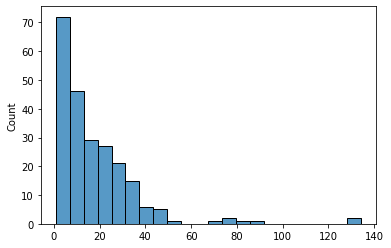

In [23]:
sns.histplot(marker_gene_table.sum(axis=1))

(1936, 1936)
(1936, 229)
0.9921302645349886
0.0


<ipython-input-2-3a11d71d3de4>:133: RuntimeWarning: invalid value encountered in true_divide
  roc = (p / n_p - (n_p + 1) / 2) / n_n


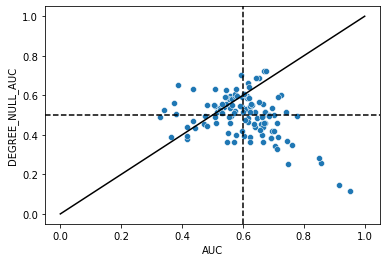

In [14]:
df_2d_jac, go_chrom  = run_egad(marker_gene_table.T, df_jac_corr)
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
sns.scatterplot(data=df_2d_jac, x='AUC', y='DEGREE_NULL_AUC')
plt.plot([0, 1], [0, 1], c='black')
plt.axvline(x=df_2d_jac['AUC'].mean(),c='black',ls='--')
plt.axhline(y=df_2d_jac['DEGREE_NULL_AUC'].mean(), c='black', ls='--')

In [31]:
df_2d_exp, go_chrom  = run_egad(marker_gene_table.T, df_exp_corr)
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
sns.scatterplot(data=df_2d_jac, x='AUC', y='DEGREE_NULL_AUC')
plt.plot([0, 1], [0, 1], c='black')
plt.axvline(x=df_2d_jac['AUC'].mean(),c='black',ls='--')
plt.axhline(y=df_2d_jac['DEGREE_NULL_AUC'].mean(), c='black', ls='--')

NameError: name 'df_exp_corr' is not defined

In [15]:
df_2d_jac['AUC'].mean()

0.6015668744373308

In [25]:
marker_gene_table.sum(axis=1).reset_index()

index   0
0       Immune system-Pro-B cells  20
1       Immune system-Pre-B cells  18
2     Immune system-Naive B cells  22
3    Immune system-Memory B cells  23
4    Immune system-Plasma B cells  23
..                            ...  ..
224            Teeth-Odontoblasts  12
225       Teeth-Endothelial cells   9
226            Teeth-Immune cells  12
227             Teeth-Glial cells   9
228        Teeth-Epithelial cells  11

[229 rows x 2 columns]

In [28]:
z = df_2d_jac.merge(marker_gene_table.sum(axis=1).reset_index(), left_on=df_2d_jac.index, right_on='index')

<AxesSubplot:xlabel='AUC', ylabel='0'>

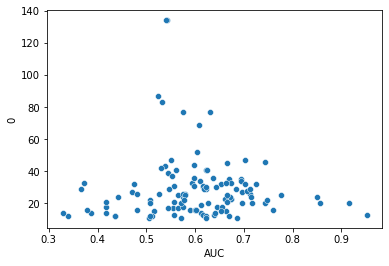

In [30]:
sns.scatterplot(x=z['AUC'], y=z[0])

In [16]:
df_2d_jac.sort_values(by=['AUC']).tail(30)

AUC  AVG_NODE_DEGREE  \
Immune system-Naive B cells                       0.668100      1160.994905   
Teeth-Immune cells                                0.669531      1050.539033   
Immune system-Memory CD8+ T cells                 0.669825      1300.562516   
Immune system-CD8+ NKT-like cells                 0.671867      1066.929353   
Immune system-Memory B cells                      0.673865      1170.448463   
Immune system-Plasma B cells                      0.673865      1170.448463   
Immune system-Effector CD8+ T cells               0.674614      1296.354202   
Immune system-Plasmacytoid Dendritic cells        0.684309      1084.440590   
Testis-Immune cells                               0.685792      1074.523348   
Eye-Tachykinin GABAergic amacrine cells           0.693520      1057.968354   
Eye-Cholinergic GABAergic amacrine cells          0.693520      1057.968354   
Pancreas-Gamma (PP) cells                         0.695343      1087.278681   
Immune system-Pro-B cells                         0.695904      1220.100514   
Gastrointestinal tract-Goblet cells               0.702615      1087.890227   
Kidney-Immune cells                               0.702998       980.354227   
Eye-GABAergic amacrine cells                      0.706003      1031.338940   
Eye-Glycinergic amacrine cells                    0.712526      1014.429892   
Immune system-Myeloid Dendritic cells             0.713403      1082.150937   
Eye-Starburst amacrine cells                      0.714736      1068.827151   
Immune system-Intermediate monocytes              0.715960      1254.113057   
Immune system--T cells                            0.724160      1229.299625   
Skin-Keratinocytes                                0.742864      1155.640164   
Immune system-Natural killer cells                0.743818      1003.977859   
White adipose tissue-Smooth Muscle cells          0.747068       887.662458   
White adipose tissue-Adipocytes                   0.759706      1016.168138   
Immune system-Non-classical monocytes             0.775968      1123.179835   
White adipose tissue-Lymphatic Endothelial cells  0.850472       987.616023   
White adipose tissue-Endothelial cells            0.856215       911.801061   
White adipose tissue-Pericytes                    0.915190       841.065357   
White adipose tissue-Endometrium                  0.952376       802.349732   

                                                  DEGREE_NULL_AUC  \
Immune system-Naive B cells                              0.502345   
Teeth-Immune cells                                       0.461105   
Immune system-Memory CD8+ T cells                        0.724414   
Immune system-CD8+ NKT-like cells                        0.458498   
Immune system-Memory B cells                             0.515178   
Immune system-Plasma B cells                             0.515178   
Immune system-Effector CD8+ T cells                      0.724657   
Immune system-Plasmacytoid Dendritic cells               0.502585   
Testis-Immune cells                                      0.493790   
Eye-Tachykinin GABAergic amacrine cells                  0.382450   
Eye-Cholinergic GABAergic amacrine cells                 0.382450   
Pancreas-Gamma (PP) cells                                0.419654   
Immune system-Pro-B cells                                0.533795   
Gastrointestinal tract-Goblet cells                      0.500115   
Kidney-Immune cells                                      0.417107   
Eye-GABAergic amacrine cells                             0.345360   
Eye-Glycinergic amacrine cells                           0.326923   
Immune system-Myeloid Dendritic cells                    0.461065   
Eye-Starburst amacrine cells                             0.388695   
Immune system-Intermediate monocytes                     0.592774   
Immune system--T cells                                   0.603609   
Skin-Keratinocytes                                       0.514366   
Immune system-Natu

(2430, 2430)
(2430, 324)
0.9943377533912513
0.0


<ipython-input-12-246835a56923>:133: RuntimeWarning: invalid value encountered in true_divide
  roc = (p / n_p - (n_p + 1) / 2) / n_n


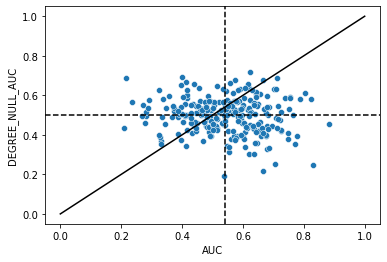

In [190]:
df_2d_jac, go_chrom  = run_egad(marker_gene_table.T, df_jac_corr_intra)
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
sns.scatterplot(data=df_2d_jac, x='AUC', y='DEGREE_NULL_AUC')
plt.plot([0, 1], [0, 1], c='black')
plt.axvline(x=df_2d_jac['AUC'].mean(),c='black',ls='--')
plt.axhline(y=df_2d_jac['DEGREE_NULL_AUC'].mean(), c='black', ls='--')

In [192]:
df_2d_jac.sort_values(by=['AUC']).tail(10)

AUC  AVG_NODE_DEGREE  \
Immune system-Neutrophils                      0.753567      1233.089870   
Placenta-IGFBP1_DKK1 positive cells            0.753950      1234.348106   
Gastrointestinal tract-Enterochromaffin cells  0.764910      1222.946982   
Immune system-Macrophages                      0.770894      1200.991514   
Intestine-Lymphoid cells                       0.778593      1208.634666   
Intestine-Erythroblasts                        0.786054      1221.515029   
Stomach-Myeloid cells                          0.804727      1234.866358   
Adrenal-Myeloid cells                          0.823953      1217.882820   
White adipose tissue-Mesothelial cells         0.830409      1190.292587   
Adrenal-CSH1_CSH2 positive cells               0.883454      1213.186840   

                                               DEGREE_NULL_AUC   P_Value  
Immune system-Neutrophils                             0.589350  0.000156  
Placenta-IGFBP1_DKK1 positive cells                   0.585967  0.002217  
Gastrointestinal tract-Enterochromaffin cells         0.500083  0.001795  
Immune system-Macrophages                             0.353940  0.012746  
Intestine-Lymphoid cells                              0.394096  0.004614  
Intestine-Erythroblasts                               0.583254  0.000067  
Stomach-Myeloid cells                                 0.610987  0.000033  
Adrenal-Myeloid cells                                 0.583111  0.001632  
White adipose tissue-Mesothelial cells                0.246800  0.000921  
Adrenal-CSH1_CSH2 positive cells                      0.455121  0.000007

(2430, 2430)
(2430, 324)
0.9943377533912513
0.0


<ipython-input-12-246835a56923>:133: RuntimeWarning: invalid value encountered in true_divide
  roc = (p / n_p - (n_p + 1) / 2) / n_n


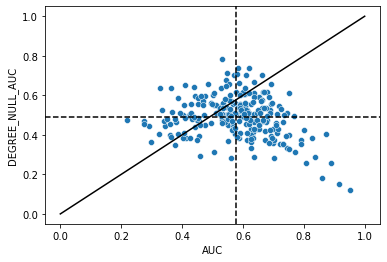

In [179]:
df_2d_jac, go_chrom  = run_egad(marker_gene_table.T, df_jac_corr)
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
sns.scatterplot(data=df_2d_jac, x='AUC', y='DEGREE_NULL_AUC')
plt.plot([0, 1], [0, 1], c='black')
plt.axvline(x=df_2d_jac['AUC'].mean(),c='black',ls='--')
plt.axhline(y=df_2d_jac['DEGREE_NULL_AUC'].mean(), c='black', ls='--')

In [184]:
df_2d_jac.sort_values(by=['AUC']).tail(10)

AUC  AVG_NODE_DEGREE  \
White adipose tissue-Adipocytes                   0.791810     6.942758e+07   
Brain-Neuroepithelial cells                       0.799741     7.563654e+07   
White adipose tissue-Smooth Muscle cells          0.807774     6.047817e+07   
Adrenal-Stromal cells                             0.825580     7.282575e+07   
White adipose tissue-Lymphatic Endothelial cells  0.836379     6.743732e+07   
White adipose tissue-Mesothelial cells            0.860274     6.058658e+07   
Immune system-Eosinophils                         0.874426     7.586037e+07   
White adipose tissue-Endothelial cells            0.890739     6.223762e+07   
White adipose tissue-Pericytes                    0.916563     5.733133e+07   
White adipose tissue-Endometrium                  0.951831     5.453354e+07   

                                                  DEGREE_NULL_AUC  \
White adipose tissue-Adipocytes                          0.353414   
Brain-Neuroepithelial cells                              0.423101   
White adipose tissue-Smooth Muscle cells                 0.256930   
Adrenal-Stromal cells                                    0.381606   
White adipose tissue-Lymphatic Endothelial cells         0.286530   
White adipose tissue-Mesothelial cells                   0.183165   
Immune system-Eosinophils                                0.406281   
White adipose tissue-Endothelial cells                   0.258882   
White adipose tissue-Pericytes                           0.152433   
White adipose tissue-Endometrium                         0.123380   

                                                       P_Value  
White adipose tissue-Adipocytes                   1.003347e-03  
Brain-Neuroepithelial cells                       5.484859e-03  
White adipose tissue-Smooth Muscle cells          5.326387e-04  
Adrenal-Stromal cells                             2.510403e-03  
White adipose tissue-Lymphatic Endothelial cells  2.986060e-07  
White adipose tissue-Mesothelial cells            2.220305e-04  
Immune system-Eosinophils                         1.556932e-04  
White adipose tissue-Endothelial cells            6.014601e-07  
White adipose tissue-Pericytes                    4.161103e-07  
White adipose tissue-Endometrium                  5.749189e-08

(2118, 2118)
(2118, 324)
0.9941666958113291
0.0


<ipython-input-12-246835a56923>:133: RuntimeWarning: invalid value encountered in true_divide
  roc = (p / n_p - (n_p + 1) / 2) / n_n


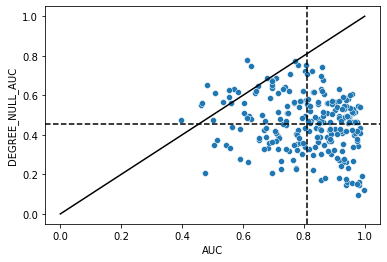

In [174]:
df_2d_exp, go_chrom  = run_egad(marker_gene_table.T, df_exp_corr)
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
sns.scatterplot(data=df_2d_exp, x='AUC', y='DEGREE_NULL_AUC')
plt.plot([0, 1], [0, 1], c='black')
plt.axvline(x=df_2d_exp['AUC'].mean(),c='black',ls='--')
plt.axhline(y=df_2d_exp['DEGREE_NULL_AUC'].mean(), c='black', ls='--')

In [175]:
df_2d_jac.reset_index(inplace=True)
df_2d_exp.reset_index(inplace=True)
coexp_contact = df_2d_jac.merge(df_2d_exp, left_on='index', right_on='index')

/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='AUC_y', ylabel='AUC_x'>

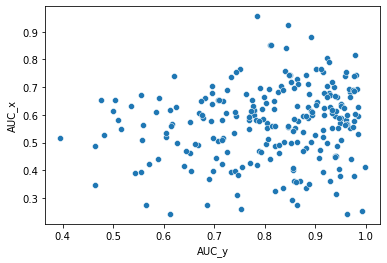

In [176]:
sns.scatterplot(coexp_contact['AUC_y'], coexp_contact['AUC_x'])

In [168]:
df_2d_exp.sort_values(by=['AUC']).tail(20)

AUC  AVG_NODE_DEGREE  \
Immune system-Basophils                    0.966514       686.331847   
Immune system-Naive CD8+ T cells           0.968314       821.950864   
Immune system-γδ-T cells                   0.968605       769.553020   
Immune system--T cells                     0.968899       769.553020   
Placenta-Lymphoid cells                    0.969792       713.832540   
Placenta-Myeloid cells                     0.973610       674.424280   
Stomach-Lymphoid cells                     0.974136       777.257123   
Placenta-Megakaryocytes                    0.975818       715.116747   
Stomach-Squamous epithelial cells          0.975893       421.026389   
Heart-Lymphoid cells                       0.976310       680.726533   
Immune system-Mast cells                   0.976431       838.248697   
Intestine-Chromaffin cells                 0.978456       351.112587   
Immune system-Eosinophils                  0.978604       644.942277   
Adrenal-Erythroblasts                      0.980016       422.470634   
Placenta-AFP_ALB positive cells            0.982184       433.979287   
Adrenal-Lymphoid cells                     0.983204       745.482143   
Immune system-ISG expressing immune cells  0.984182       845.937118   
Intestine-Lymphoid cells                   0.984755       729.664059   
Muscle-Erythroblasts                       0.992657       456.658236   
Intestine-Erythroblasts                    0.997374       395.921133   

                                           DEGREE_NULL_AUC       P_Value  
Immune system-Basophils                           0.396859  8.957349e-08  
Immune system-Naive CD8+ T cells                  0.515133  4.288808e-10  
Immune system-γδ-T cells                          0.464349  8.119871e-11  
Immune system--T cells                            0.464349  5.924728e-11  
Placenta-Lymphoid cells                           0.411246  2.444644e-08  
Placenta-Myeloid cells                            0.380619  8.182613e-09  
Stomach-Lymphoid cells                            0.467312  2.445967e-09  
Placenta-Megakaryocytes                           0.416996  4.939503e-07  
Stomach-Squamous epithelial cells                 0.149151  1.253213e-05  
Heart-Lymphoid cells                              0.368074  4.947886e-10  
Immune system-Mast cells                          0.545533  3.501668e-05  
Intestine-Chromaffin cells                        0.098011  3.959878e-05  
Immune system-Eosinophils                         0.343304  5.867062e-04  
Adrenal-Erythroblasts                             0.146979  2.215531e-06  
Placenta-AFP_ALB positive cells                   0.163472  1.149528e-07  
Adrenal-Lymphoid cells                            0.433682  4.165141e-09  
Immune system-ISG expressing immune cells         0.540646  3.247684e-07  
Intestine-Lymphoid cells                          0.410782  1.164714e-06  
Muscle-Erythroblasts                              0.193468  8.335917e-09  
Intestine-Erythroblasts                           0.122622  7.362984e-09

In [169]:
df_2d_jac.sort_values(by=['AUC']).tail(20)

AUC  AVG_NODE_DEGREE  \
Adrenal-Erythroblasts                             0.744015     7.830639e+07   
Eye-GABAergic amacrine cells                      0.745241     7.268417e+07   
Stomach-PDE1C_ACSM3 positive cells                0.754132     7.301663e+07   
Heart-Megakaryocytes                              0.754374     7.470928e+07   
Immune system-Intermediate monocytes              0.755359     8.918103e+07   
Adrenal-SLC26A4_PAEP positive cells               0.757836     8.059366e+07   
Eye-Glycinergic amacrine cells                    0.758436     7.143455e+07   
Immune system-Non-classical monocytes             0.765285     7.983960e+07   
Adrenal-Stromal cells                             0.766023     7.476892e+07   
Spleen-Stromal cells                              0.767047     6.456358e+07   
White adipose tissue-Adipocytes                   0.789524     7.134295e+07   
Adrenal-CSH1_CSH2 positive cells                  0.800541     8.125798e+07   
Brain-Neuroepithelial cells                       0.805471     7.778916e+07   
Immune system-Eosinophils                         0.817843     7.799499e+07   
White adipose tissue-Mesothelial cells            0.842210     6.219281e+07   
White adipose tissue-Lymphatic Endothelial cells  0.851003     6.926410e+07   
White adipose tissue-Endothelial cells            0.853651     6.394237e+07   
White adipose tissue-Adipose progenitor cells     0.879674     6.533446e+07   
White adipose tissue-Pericytes                    0.924143     5.884099e+07   
White adipose tissue-Endometrium                  0.955802     5.597243e+07   

                                                  DEGREE_NULL_AUC  \
Adrenal-Erythroblasts                                    0.472669   
Eye-GABAergic amacrine cells                             0.350712   
Stomach-PDE1C_ACSM3 positive cells                       0.374127   
Heart-Megakaryocytes                                     0.413942   
Immune system-Intermediate monocytes                     0.611174   
Adrenal-SLC26A4_PAEP positive cells                      0.496535   
Eye-Glycinergic amacrine cells                           0.331923   
Immune system-Non-classical monocytes                    0.509710   
Adrenal-Stromal cells                                    0.379877   
Spleen-Stromal cells                                     0.327521   
White adipose tissue-Adipocytes                          0.352323   
Adrenal-CSH1_CSH2 positive cells                         0.406855   
Brain-Neuroepithelial cells                              0.421812   
Immune system-Eosinophils                                0.404308   
White adipose tissue-Mesothelial cells                   0.181567   
White adipose tissue-Lymphatic Endothelial cells         0.284352   
White adipose tissue-Endothelial cells                   0.258357   
White adipose tissue-Adipose progenitor cells            0.314332   
White adipose tissue-Pericytes                           0.151323   
White adipose tissue-Endometrium                         0.122448   

                                                       P_Value  
Adrenal-Erythroblasts                             1.577830e-02  
Eye-GABAergic amacrine cells                      1.214904e-02  
Stomach-PDE1C_ACSM3 positive cells                1.073852e-03  
Heart-Megakaryocytes                              1.688054e-03  
Immune system-Intermediate monocytes              2.788973e-03  
Adrenal-SLC26A4_PAEP positive cells               1.268912e-02  
Eye-Glycinergic amacrine cells                    6.499352e-03  
Immune system-Non-classical monocytes             2.098806e-04  
Adrenal-Stromal cells                             5.048967e-03  
Spleen-Stromal cells                              3.439434e-03  
White adipose tissue-Adipocytes                   1.522735e-03  
Adrenal-CSH1_CSH2 positive cells                  8.298341e-05  
Brain-Neuroepithelial cells                       2.012711e-03  
Immune system-Eosinophils          

In [215]:
y = marker_gene_table.T

genes_intersect = y.index.intersection(df_jac_corr.index)

nw = df_jac_corr.loc[genes_intersect, genes_intersect]

marker_gene_table = marker_gene_table.loc[:, genes_intersect]

In [216]:
species= marker_gene_table.T.idxmax(axis=1)

In [218]:
species.unique()

array(['Brain-Immune system cells', 'Brain-Microglial cells',
       'Brain-Astrocytes', 'Brain-Oligodendrocytes',
       'Brain-Dopaminergic neurons', 'Brain-GABAergic neurons',
       'Brain-Neuroblasts', 'Brain-Endothelial cells',
       'Brain-Cholinergic neurons', 'Brain-Radial glial cells',
       'Brain-Mature neurons', 'Brain-Neural Progenitor cells',
       'Brain-Immature neurons', 'Brain-Neuroepithelial cells',
       'Brain-Glutamatergic neurons', 'Brain-Tanycytes',
       'Brain-Non myelinating Schwann cells',
       'Brain-Oligodendrocyte precursor cells',
       'Brain-Myelinating Schwann cells', 'Brain-Cancer cells',
       'Brain-Cancer stem cells', 'Brain-Neural stem cells',
       'Brain-Serotonergic neurons', 'Brain-Schwann precursor cells'],
      dtype=object)

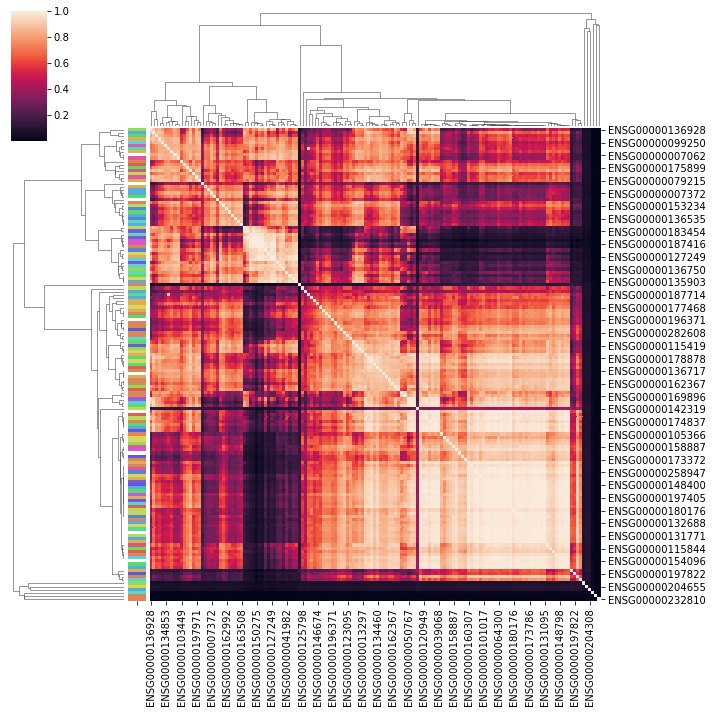

In [219]:
lut = dict(zip(species.unique(), sns.color_palette("hls", 20)))
#lut = dict(zip(species.unique(), "grrbrrryry"))
#lut = dict(zip(species.unique(), "rrbb"))
#lut = dict(zip(['Brain-Astrocytes', 'Brain-Endothelial cells', 'Brain-Microglial cells','Brain-GABAergic neurons'], sns.color_palette("hls", 4)))
row_colors = species.map(lut)
g = sns.clustermap(nw, row_colors=row_colors, row_cluster=True, metric="correlation")
